# Modelling data

- Select features for training and testing model
- Normalize values on a *per-column* basis* [0-1]

*Do features need to be dimensionally reduced?*

In [187]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import os
import pickle

In [188]:
df = pd.read_csv('working/combined.csv')

### Re-order columns

Separate columns into risk factors, cognitive and mri features

In [189]:
df.shape

(564, 197)

In [190]:
# reorder columns
cols = df.columns.to_list()

mri_cols = cols[1:178]
rest_cols = cols[178:]
risk_cols = [
    'RID', 'AGE', 'PTGENDER',
    'PTEDUCAT', 'MOTHDEM', 'FATHDEM'
]
cognitive_cols = [c for c in rest_cols if c not in risk_cols]

In [191]:
cols = risk_cols + cognitive_cols + mri_cols
df = df.reindex(columns=cols)

In [192]:
df.head()

,RID,AGE,PTGENDER,PTEDUCAT,MOTHDEM,FATHDEM,PHC_MEM,PHC_EXF,PHC_LAN,AD_LABEL,...,wm-rh-superiorfrontal,wm-rh-superiorparietal,wm-rh-superiortemporal,wm-rh-supramarginal,wm-rh-frontalpole,wm-rh-temporalpole,wm-rh-transversetemporal,wm-rh-insula,wm-lh-Unsegmented,wm-rh-Unsegmented
0,21,84.8186,2,18.0,0.0,0.0,1.173,-0.150,0.666,1.0,...,1.134314,1.018792,1.385129,1.172204,1.206521,1.469661,1.182140,1.214626,1.614727,1.587751
1,31,91.3073,2,18.0,0.0,0.0,1.038,-0.318,0.269,1.0,...,1.278840,1.128747,1.351128,1.211336,1.434194,1.470025,1.788683,1.324016,0.730924,0.814179
2,56,83.7563,2,13.0,0.0,0.0,0.349,0.090,0.155,2.0,...,1.260969,1.316324,1.271024,1.296633,1.447026,1.191524,1.020604,1.384523,1.323594,1.330080
3,59,84.9665,2,13.0,0.0,0.0,0.485,0.405,0.236,2.0,...,1.266842,1.245742,1.207279,1.322977,1.284196,1.209476,1.008124,1.253794,1.447955,1.407817
4,69,87.0582,1,16.0,0.0,0.0,0.087,1.025,1.060,2.0,...,1.381038,1.418930,1.426585,1.400109,1.566343,1.650883,1.144346,1.416124,0.863427,0.926379


### Gender

Update gender to be $[0,1]$ where:
- $0 \rightarrow$ Male
- $1 \rightarrow$ Female

In [193]:
df['PTGENDER'] = df['PTGENDER'] - 1

### Negative cols

Make all negative cols positive before normalization.

See article under heading [normalizing negative data](https://people.revoledu.com/kardi/tutorial/Similarity/Normalization.html).

In [194]:
negative_cols = [k for k,v in df.items() if v.min() < 0]

In [195]:
for k, v in df[negative_cols].items():
    df[k] = df[k].map(lambda x: x + abs(v.min()))

### Normalize columns

Now that all columns contain positive values, normalize
all features where $\max > 1$.

Normalize features using *min-max scaling*

In [196]:
# copy original df before normalizing
original_df = df.copy()

In [197]:
# NOTE: if you remove the CDR score you won't have to adjust
# your array indexes when exporting later, just the number of features
excluded = ['RID', 'AD_LABEL', 'CDR']
cols_to_normalize = [k for k, v in df.items() if v.max() > 1 and k not in excluded]

In [198]:
normalized_df = df[cols_to_normalize]
numer = normalized_df - normalized_df.min()
denom = normalized_df.max() - normalized_df.min()

df[cols_to_normalize] = (numer / denom)

In [199]:
# convert dataframe into numpy array (excl. rid and label)
cols_to_keep = [c for c in df.columns if c not in excluded]
arr = df.loc[:, cols_to_keep].values

### Cluster with existing labels

- Cluster datapoints using UMAP
- Dictate what each cluster represents
- Visualise clusters
- Reassign labels based on position in UMAP cluster

In [200]:
SEED = 2020
clusterable_embedding = umap.UMAP(
    n_neighbors=5,
    min_dist=0.0,
    n_components=3,
    random_state=SEED
)
clusterable_embedding.fit_transform(arr)
embeddings = clusterable_embedding.embedding_

Note how the nodes have been clustered. As we can see, there is a clear sepearation between patient's with AD (3) and CN (1).

More importantly is the tight clustering of CN and MCI nodes that reside on just outside the main AD cluster. I suspect that many of these CN patient's have been clinically diagnosed as healthy, however, if we were to use the clusters as a guide, they would infact be classed as MCI based on their neighbour relation.

**Cluster bounds in 2-D space**
- AD Bounds $\rightarrow x:[-2.5, 1], \ y:[1.6, 4.2]$
- MCI Bounds (excl. AD bounds) $\rightarrow x:[-5, 1.2], \ y:[-2, 8]$
- CN $\rightarrow$ remaining coordinates

Text(0.2, 2, 'Suggested AD bounds')

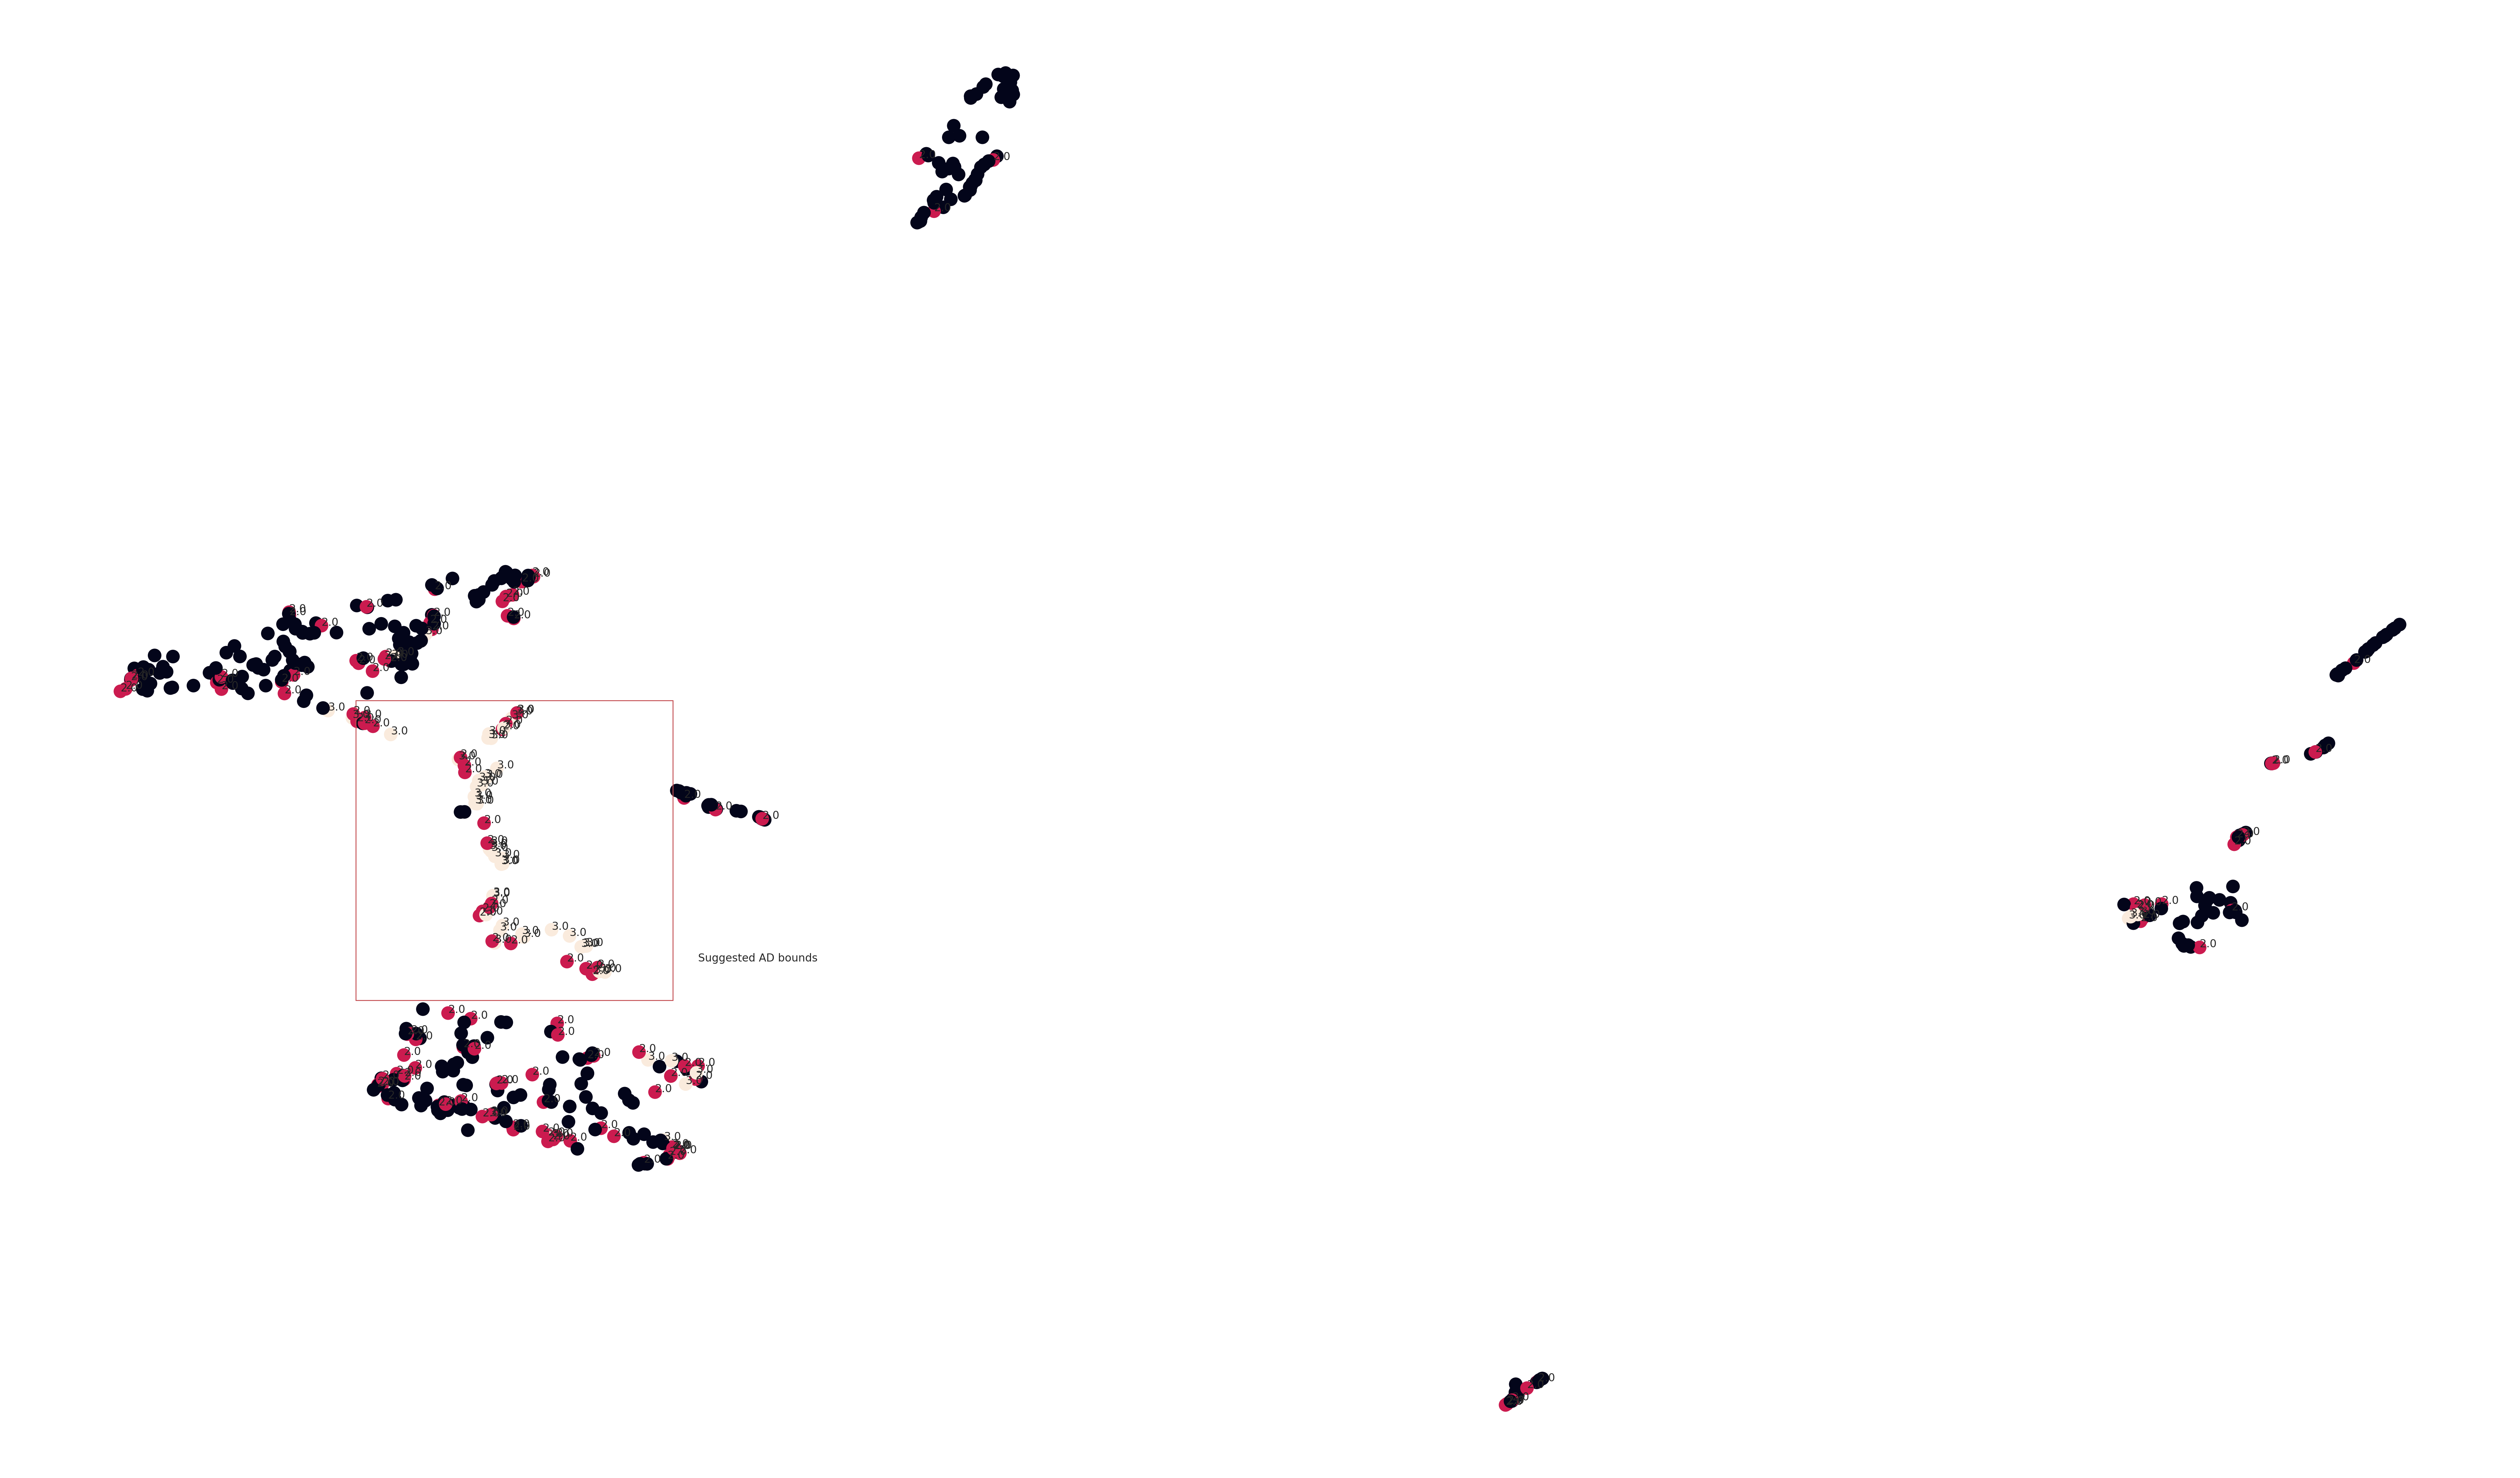

In [201]:
# configure plt
fig, ax = plt.subplots(figsize=(50, 30), dpi=200)
ax.axis('off')

x = embeddings[:, 0]
y = embeddings[:, 1]
plt.scatter(x, y, c=df['AD_LABEL'], s=200);

# save figure before labelling
fig.savefig('plots/umap_ad_clusters.png', dpi=200)

# append real labels to UMAP points
for i, label in enumerate(df['AD_LABEL']):
    if label in {2, 3}:
        ax.annotate(label, (x[i], y[i]))
        
# visualize bounds
rect = Rectangle(
    (-2.5, 1.6),
    2.5, 3.1,
    edgecolor='r',
    linewidth=1,
    label="Suggested AD bounds",
    fill=False
)
plt.gca().add_patch(rect)
ax.annotate("Suggested AD bounds", (0.2, 2))

**Understand bounds from CDR score**

Text(0.2, 2, 'Suggested CDR 2.0 bounds')

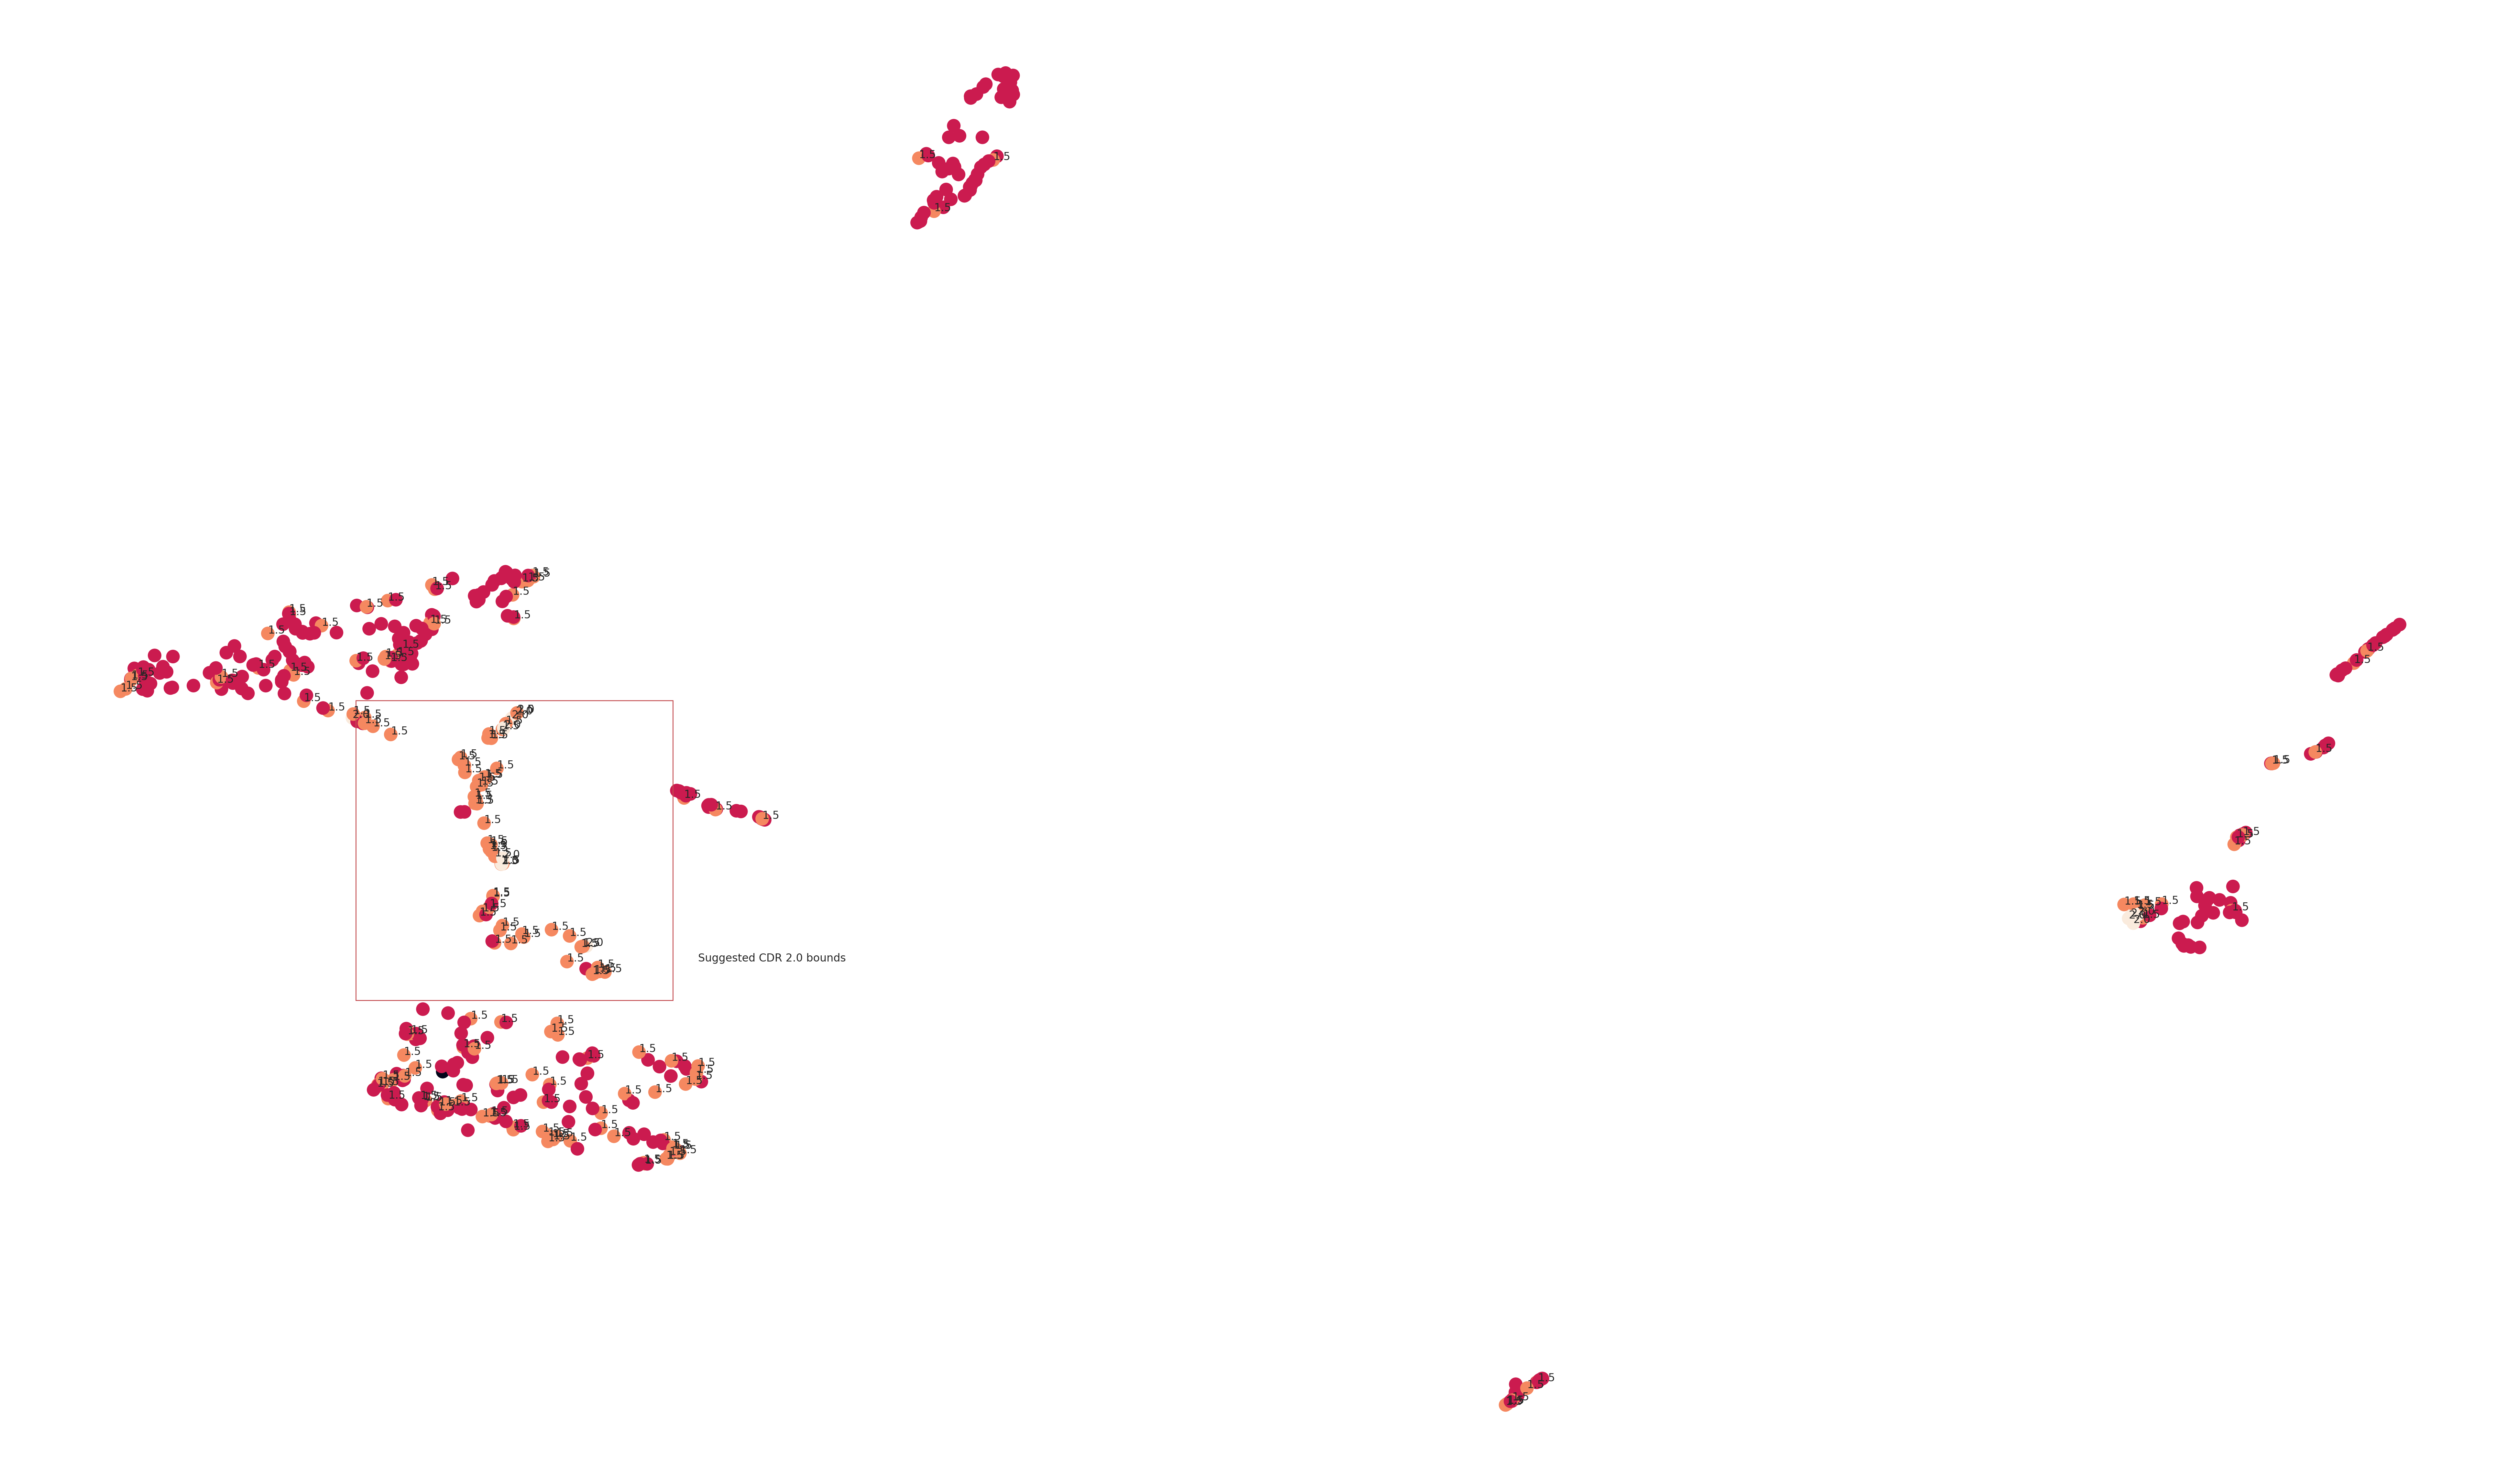

In [202]:
# configure plt
fig, ax = plt.subplots(figsize=(50, 30), dpi=200)
ax.axis('off')

x = embeddings[:, 0]
y = embeddings[:, 1]
plt.scatter(x, y, c=df['CDR'], s=200);

# save figure before labelling
fig.savefig('plots/umap_cdr_clusters.png', dpi=200)

# append real labels to UMAP points
for i, label in enumerate(df['CDR']):
    if label in {2, 1.5}:
        ax.annotate(label, (x[i], y[i]))
        
# visualize bounds
rect = Rectangle(
    (-2.5, 1.6),
    2.5, 3.1,
    edgecolor='r',
    linewidth=1,
    label="Suggested CDR 2.0 bounds",
    fill=False
)
plt.gca().add_patch(rect)
ax.annotate("Suggested CDR 2.0 bounds", (0.2, 2))

**Understand AD bounds from a 3-D perspective**

It's important to factor in the *z-axis* when deciding on final bounds.

In [203]:
# configure 3-D plot
import plotly.express as px

x = embeddings[:, 0]
y = embeddings[:, 1]
z = embeddings[:, 2]

columns = ['umap_comp_1', 'umap_comp_3', 'umap_comp_3']
scatter_df = pd.DataFrame(data=embeddings, columns=['a', 'b', 'c'])

# add all of the original df datapoints to scatter df for hover data
scatter_df = pd.merge(scatter_df, df, left_index=True, right_index=True)
fig = px.scatter_3d(
    scatter_df,
    x='a',
    y='b',
    z='c',
    color='AD_LABEL',
    opacity=0.7,
    hover_data=['AGE', 'CDR', 'MMSE']
)

# Default parameters which are used when `layout.scene.camera` is not provided
name = 'Supervised scatter plot'
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.25, y=1.25, z=1.25)
)
fig.update_layout(scene_camera=camera, title=name)
fig.show()

### Cluster with unsupervised labels

Using the decided boundaries, each point's label was re-assigned according to where it sits in the boundary.

In [204]:
# reassign labels based on co-ordinates using upper and lower bound ranges
MCI_bounds = {'lx': -5, 'ux': 0, 'ly': -2, 'uy': 8, 'lz': -2, 'uz': 7}
AD_bounds = {'lx': -2.5, 'ux': 0, 'ly': 1.6, 'uy': 4.7, 'lz': 1.5, 'uz': 4.8 }

def relabel_point(point):
    """Assign unsupervised label based on cluster boundaries."""
    label = 1
    x, y, z = point
    
    in_x_bounds = MCI_bounds['lx'] < x < MCI_bounds['ux']
    in_y_bounds = MCI_bounds['ly'] < y < MCI_bounds['uy']
    in_z_bounds = AD_bounds['lz'] < z < AD_bounds['uz']
    if not in_x_bounds or not in_y_bounds and in_z_bounds:
        return label
        
    label = 2
    if in_x_bounds or in_y_bounds:
        in_x_bounds = AD_bounds['lx'] < x < AD_bounds['ux']
        in_y_bounds = AD_bounds['ly'] < y < AD_bounds['uy']
        in_z_bounds = AD_bounds['lz'] < z < AD_bounds['uz']
        if in_x_bounds and in_y_bounds and in_z_bounds:
            label = 3
            
    return label
    

unsupervised_labels = [relabel_point(p) for p in embeddings]
unsupervised_label_s = pd.Series(data=unsupervised_labels, dtype='float64')

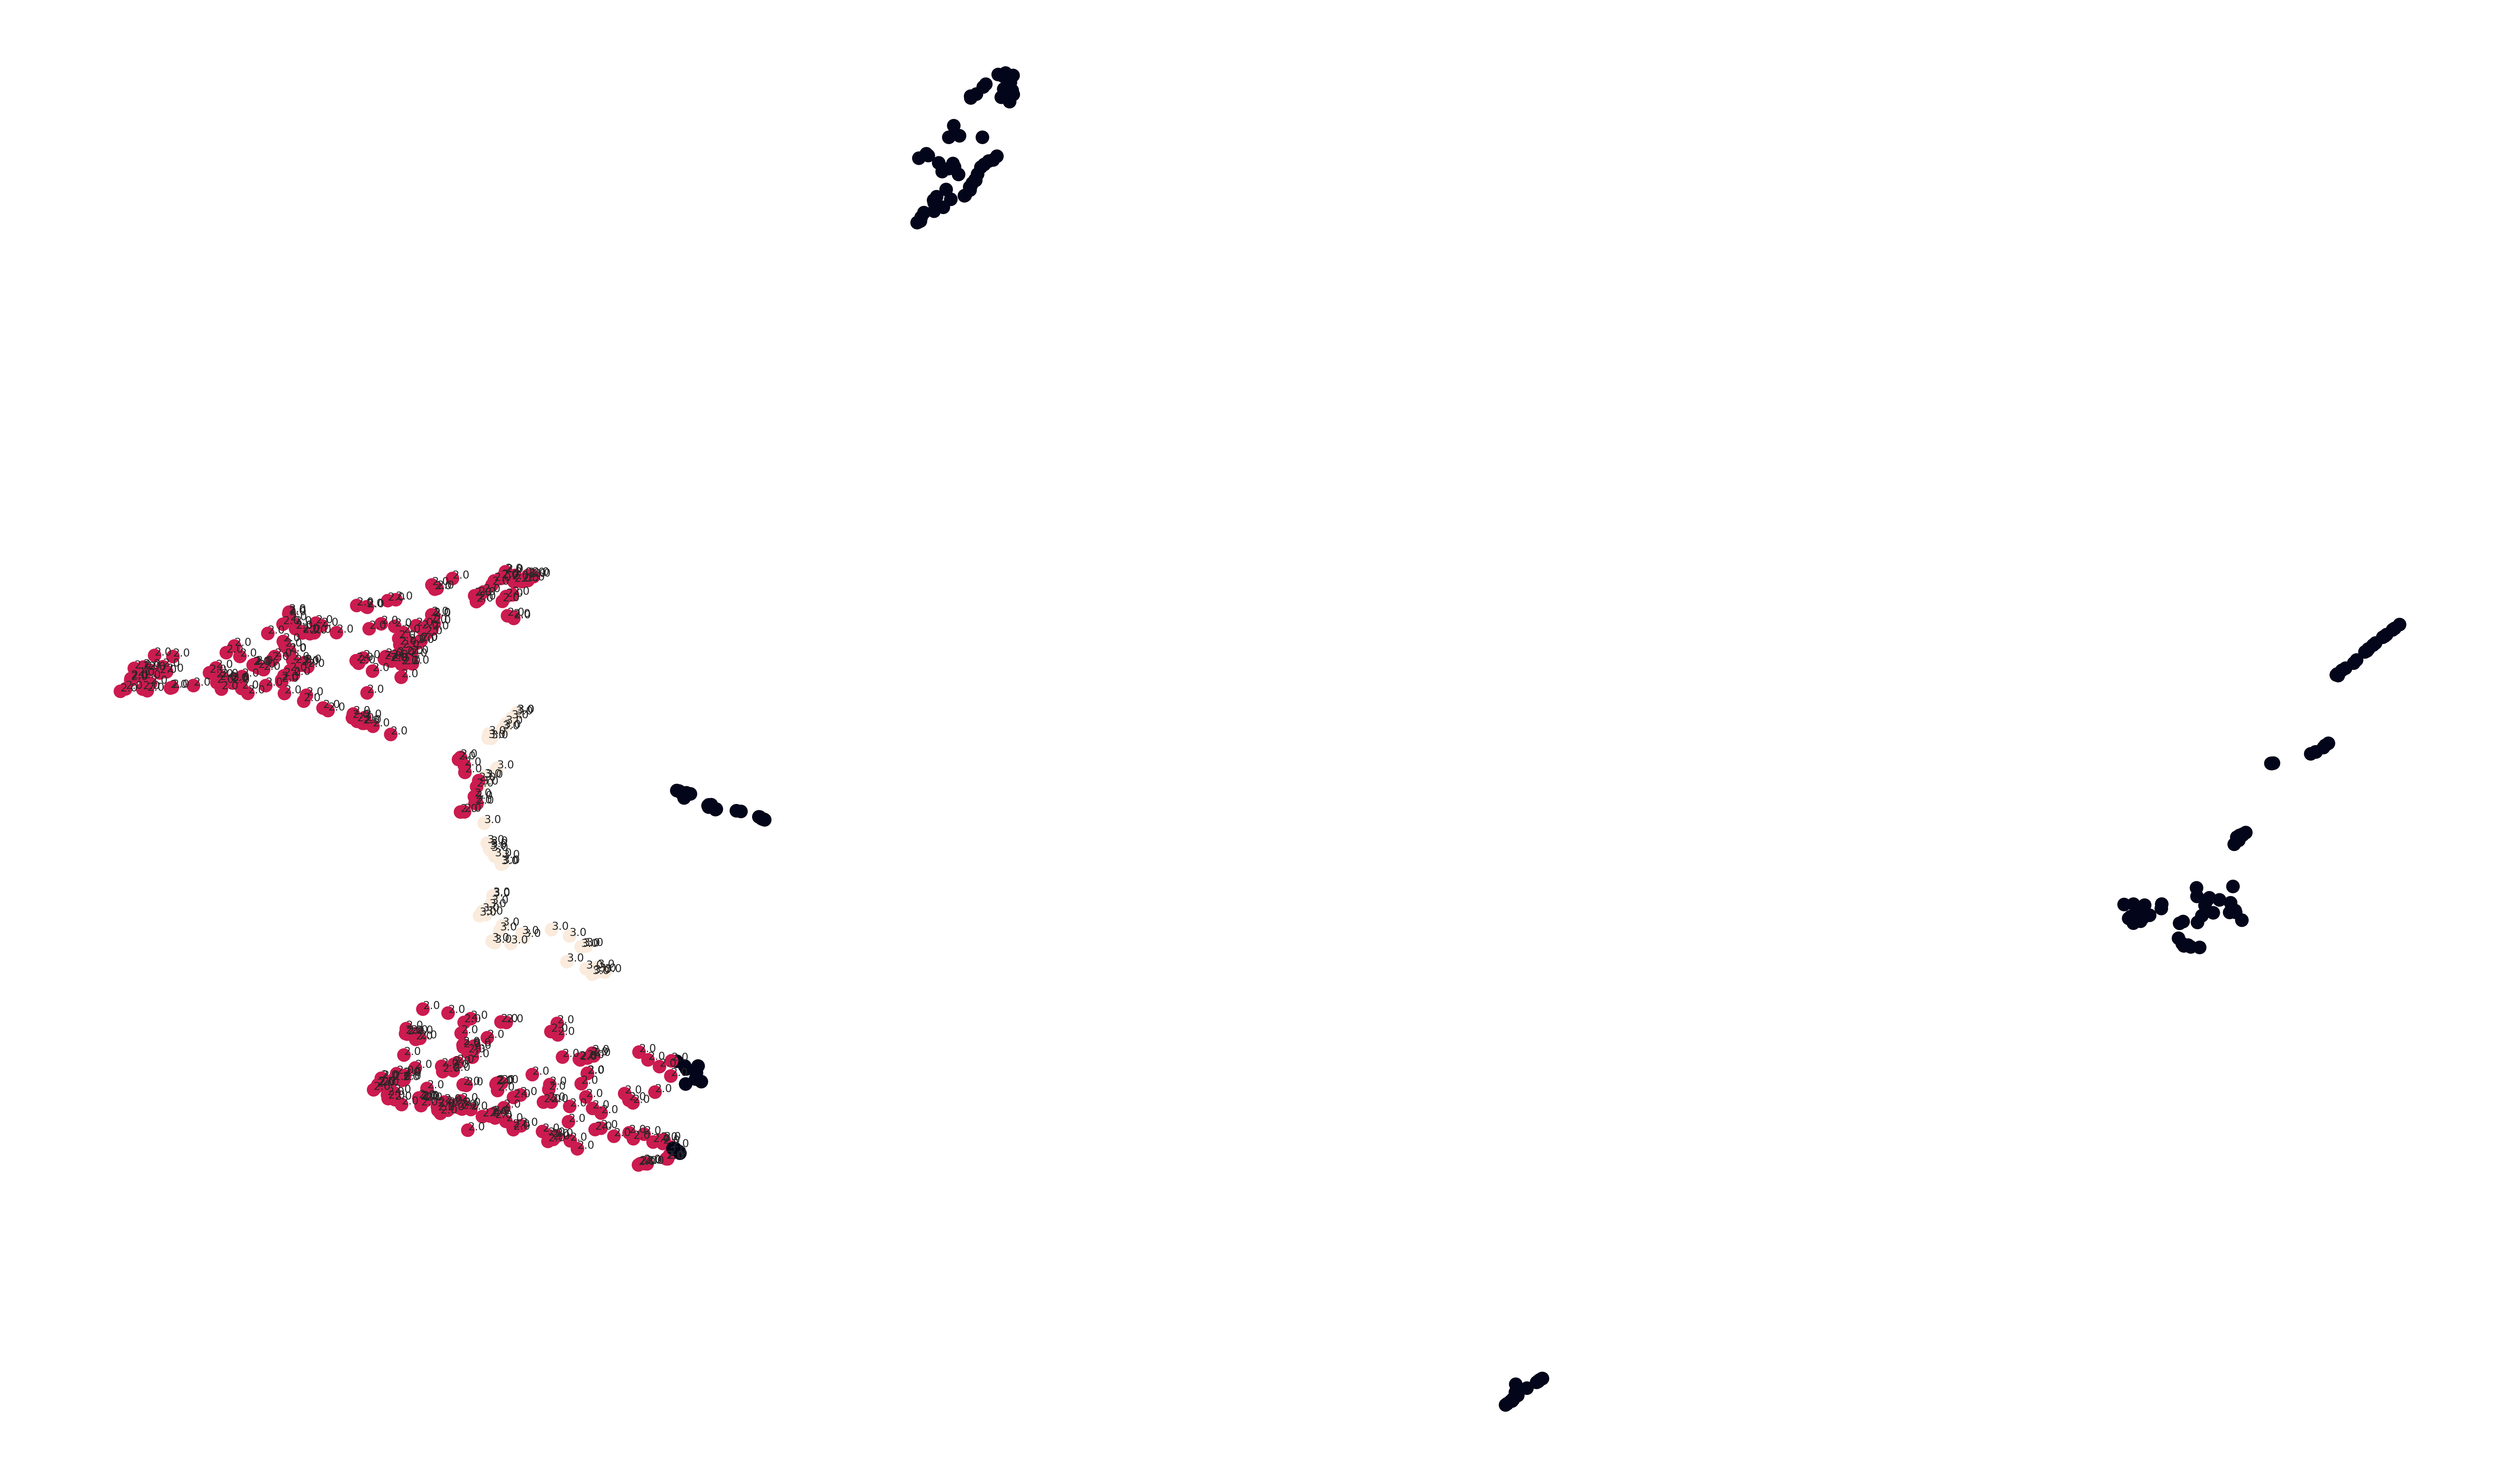

In [205]:
# configure plt
fig, ax = plt.subplots(figsize=(50, 30), dpi=200)
ax.axis('off')

# redraw scatterplot using new labels
x = embeddings[:, 0]
y = embeddings[:, 1]
plt.scatter(x, y, c=unsupervised_label_s, s=200);
        
# save figure before labelling
fig.savefig('plots/umap_ad_clusters_reassigned.png', dpi=200)

# append real labels to UMAP points
for i, label in enumerate(unsupervised_label_s):
    if label in {2, 3}:
        ax.annotate(label, (x[i], y[i]))

In [206]:
# configure 3-D plot
import plotly.express as px

x = embeddings[:, 0]
y = embeddings[:, 1]
z = embeddings[:, 2]

columns = ['umap_comp_1', 'umap_comp_3', 'umap_comp_3']
scatter_df = pd.DataFrame(data=embeddings, columns=['a', 'b', 'c'])

# add all of the original df datapoints to scatter df for hover data
scatter_df = pd.merge(scatter_df, df, left_index=True, right_index=True)
fig = px.scatter_3d(
    scatter_df,
    x='a',
    y='b',
    z='c',
    color=unsupervised_label_s,
    opacity=0.7,
    hover_data=['AGE', 'CDR', 'MMSE'],
)

# Default parameters which are used when `layout.scene.camera` is not provided
name = 'Unsupervised scatter plot'
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.25, y=1.25, z=1.25)
)
fig.update_layout(scene_camera=camera, title=name)
fig.show()

### Find ranges

Determine the *entry point* of each AD classification boundary by finding the ranges for each class.

In [207]:
# replace real-labels with unsupervised labels
original_df['AD_LABEL'] = unsupervised_label_s

In [208]:
ad_ranges = original_df.groupby(by='AD_LABEL').agg(['min', 'max'])
ad_ranges

RID            AGE          PTGENDER     PTEDUCAT       MOTHDEM  \
          min   max      min      max      min max      min   max     min   
AD_LABEL                                                                    
1.0        96  6624  56.9637  92.8433        0   1     12.0  20.0     0.0   
2.0        21  6605  58.5161  93.5551        0   1      8.0  20.0     0.0   
3.0       112  6602  56.5448  95.0062        0   1     12.0  20.0     0.0   

               ... wm-rh-temporalpole           wm-rh-transversetemporal  \
          max  ...                min       max                      min   
AD_LABEL       ...                                                         
1.0       1.0  ...           0.742063  2.336712                 0.409969   
2.0       1.0  ...           0.820385  2.287555                 0.548431   
3.0       1.0  ...           0.675811  3.487843                 0.498649   

                   wm-rh-insula           wm-lh-Unsegmented            \
               max          min       max               min       max   
AD_LABEL                                                                
1.0       1.578850     0.849936  1.709476          0.598425  1.678433   
2.0       1.788683     0.902095  1.766894          0.645537  1.884873   
3.0       2.751318     0.920446  2.701695          0.694844  2.385331   

         wm-rh-Unsegmented            
                       min       max  
AD_LABEL                              
1.0               0.548918  1.715366  
2.0               0.619474  1.845602  
3.0               0.686599  1.849129  

[3 rows x 392 columns]

In [209]:
# print ranges for patient's labelled with unsupervised learning label 3
ad_df = original_df[original_df['AD_LABEL'] == 3]
ad_df.describe()

,RID,AGE,PTGENDER,PTEDUCAT,MOTHDEM,FATHDEM,PHC_MEM,PHC_EXF,PHC_LAN,AD_LABEL,...,wm-rh-superiorfrontal,wm-rh-superiorparietal,wm-rh-superiortemporal,wm-rh-supramarginal,wm-rh-frontalpole,wm-rh-temporalpole,wm-rh-transversetemporal,wm-rh-insula,wm-lh-Unsegmented,wm-rh-Unsegmented
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.0,...,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,4660.137255,76.832576,0.372549,15.843137,0.215686,0.058824,1.633294,1.855725,1.800176,3.0,...,1.644166,2.048965,1.598738,1.931345,1.557193,1.836538,1.036989,1.494899,1.249699,1.249134
std,1991.358762,9.586747,0.488294,2.335573,0.415390,0.237635,0.537036,0.790634,0.564601,0.0,...,0.675025,1.426545,0.506340,0.966726,0.637526,0.560119,0.380848,0.320453,0.296604,0.268668
min,112.000000,56.544800,0.000000,12.000000,0.000000,0.000000,0.239000,0.266000,0.000000,3.0,...,0.833051,0.860389,0.975231,0.934456,0.659928,0.675811,0.498649,0.920446,0.694844,0.686599
25%,4274.500000,70.134150,0.000000,14.000000,0.000000,0.000000,1.282500,1.351000,1.502500,3.0,...,1.219405,1.272374,1.280887,1.294328,1.143914,1.510424,0.841535,1.330436,1.076375,1.051936
50%,4891.000000,79.252600,0.000000,16.000000,0.000000,0.000000,1.608000,2.062000,1.924000,3.0,...,1.454137,1.487629,1.511029,1.684093,1.399425,1.669230,1.006863,1.451890,1.207074,1.212843
75%,6293.500000,83.225150,1.000000,18.000000,0.000000,0.000000,1.994000,2.425500,2.150000,3.0,...,1.848587,2.340097,1.773127,2.127034,1.789669,2.095677,1.149645,1.624783,1.351169,1.422179
max,6602.000000,95.006200,1.000000,20.000000,1.000000,1.000000,2.869000,3.253000,2.793000,3.0,...,4.558964,8.398602,3.289058,5.421748,4.049399,3.487843,2.751318,2.701695,2.385331,1.849129


**Plot ranges**

In [210]:
ad_ranges.to_csv('data/unsupervised_ad_ranges.csv')

### Export

- Convert dataframe to numpy array (excl. rid and label)
- Create data dictionary

In [211]:
# replace real-labels with unsupervised labels
df['AD_LABEL'] = unsupervised_label_s

In [212]:
keys = ['CN', 'MCI', 'AD' ]
data_dict = {k: [] for k in keys}

for i, subj in enumerate(arr):
    key = int(df['AD_LABEL'][i]) - 1
    item = np.expand_dims(subj, axis=0)
    data_dict[keys[key]].append(item)

In [213]:
# separate data dictionary into training and test sets
train_dict = {}
test_dict = {}
for k, v in data_dict.items():
    no_train_samples = round(len(v) * .80)
    train_dict[k] = v[:no_train_samples]
    test_dict[k] = v[no_train_samples:]

In [214]:
if not os.path.exists('data/'):
    os.mkdir('data/')

In [215]:
np.save('data/ad_unsupervised_class_train', train_dict, allow_pickle=True)

In [216]:
np.save('data/ad_unsupervised_class_test', test_dict, allow_pickle=True)

### Log

Keep track of datashape and where features sit for future usage.

**Order of features in array are as follows:**

*Risk factors* $\rightarrow$ *Cognitive factors* $\rightarrow$ *MRI factors*

In [217]:
print([(k, len(v)) for k,v in train_dict.items()])
print([(k, len(v)) for k,v in test_dict.items()])

# we have removed rid from risk cols and ad_label from cognitive cols
# NOTE: if we decide to remove CDR then cognitive cols - 2
print(f"""
    Risk features (excl. rid): {len(risk_cols) - 1},
    Cognitive features (excl. label): {len(cognitive_cols) - 2},
    MRI cols: {len(mri_cols)}
""")

[('CN', 152), ('MCI', 258), ('AD', 41)]
[('CN', 38), ('MCI', 65), ('AD', 10)]

    Risk features (excl. rid): 5,
    Cognitive features (excl. label): 12,
    MRI cols: 177



### Data loading test

In [218]:
test_root = 'data/ad_class_train.npy'
with open(test_root, 'rb') as f:
    data_dict = np.load(f, allow_pickle=True)

# load object in numpy using data_dict[()]['AD']

In [219]:
data_dict[()]['AD'][0]

array([[0.6934069 , 0.        , 0.83333333, 0.        , 0.        ,
        0.30626023, 0.61769956, 0.40131437, 0.30733206, 0.76850211,
        0.84615385, 0.        , 0.04918033, 0.56521739, 0.47826087,
        0.31225047, 0.49602302, 0.48687168, 0.55034526, 0.23328005,
        0.25137255, 0.66739609, 0.14982578, 0.3935899 , 0.28211031,
        0.60698206, 0.36265916, 0.49857326, 0.30694524, 0.52610557,
        0.51844572, 0.08747958, 0.44354742, 0.60496959, 0.24449593,
        0.14651356, 0.59559876, 0.11961297, 0.2970036 , 0.47124603,
        0.34294008, 0.54375861, 0.07236322, 0.34860891, 0.        ,
        0.        , 0.        , 0.17561781, 0.61345251, 0.12282124,
        0.29954476, 0.18425925, 0.2721465 , 0.10019129, 0.3935871 ,
        0.32728262, 0.07167696, 0.27436288, 0.19766599, 0.06163092,
        0.24838172, 0.21448134, 0.41819001, 0.1813811 , 0.56666207,
        0.32984083, 0.21373426, 0.1252416 , 0.11028754, 0.20612522,
        0.25791234, 0.1931159 , 0.24770914, 0.13